# How to use the ECB API with Python
https://ramin.org/posts/ecb-api-python

In [1]:
import sdmx
import pandas as pd

ecb = sdmx.Client("ECB")

In [2]:
def get_available_dataflows(client):
    dataflow_message = client.dataflow()
    dataflows_df = sdmx.to_pandas(dataflow_message.dataflow)
    dataflows_df.name = f"{client.source.id} Dataflows"
    return dataflows_df

dataflows = get_available_dataflows(ecb)
dataflows

AGR                                              AGR
AME                                            AMECO
BKN                             Banknotes statistics
BLS                   Bank Lending Survey Statistics
BNT    Shipments of Euro Banknotes Statistics (ESCB)
                           ...                      
SUR                                  Opinion Surveys
TGB                                  Target Balances
TRD                                   External Trade
WTS                                    Trade weights
YC               Financial market data - yield curve
Name: ECB Dataflows, Length: 97, dtype: object

In [3]:
def get_dataflow_metadata(client, dataflow_id):
    dataflow_message = ecb.dataflow(dataflow_id)
    return (
        dataflow_message.dataflow[dataflow_id].structure,
        dataflow_message.constraint[f"{dataflow_id}_CONSTRAINTS"].data_content_region[0],
        dataflow_message.dataflow[dataflow_id].name
    )

yc_data_structure_definition, yc_constraints, yc_name = get_dataflow_metadata(ecb, 'YC')
yc_data_structure_definition

<DataStructureDefinition ECB:ECB_FMD2(1.0): Financial market data (not related to foreign exchange)>

In [4]:
def get_dataflow_dimensions(data_structure_definition, dataflow_name):
    dimensions = data_structure_definition.dimensions
    return pd.Series({
        dimension.id: dimension.concept_identity.name
        for dimension in dimensions
    }, name=f"'{dataflow_name}' Dimensions")

yc_dimensions = get_dataflow_dimensions(yc_data_structure_definition, yc_name)
yc_dimensions

FREQ                                         Frequency
REF_AREA                                Reference area
CURRENCY                                      Currency
PROVIDER_FM                  Financial market provider
INSTRUMENT_FM              Financial market instrument
PROVIDER_FM_ID    Financial market provider identifier
DATA_TYPE_FM                Financial market data type
TIME_PERIOD                       Time period or range
Name: 'Financial market data - yield curve' Dimensions, dtype: object

In [5]:
def get_code_description(code, dimension):
    codelist = dimension.local_representation.enumerated
    return codelist[code].name

def get_constraint_codes(constraints, dimension):
    try:
        codes = constraints.member[dimension.id].values
    except:
        return pd.Series(name=f"'{dimension.id}' Codes", dtype='object')

    codes_with_description = {
        code.value: get_code_description(code.value, dimension)
        for code in codes
    }
    return pd.Series(codes_with_description, name=f"'{dimension.id}' Codes")


def get_constraints_with_codes(data_structure_definition, constraints):
    dimensions = data_structure_definition.dimensions
    return [
        get_constraint_codes(constraints, dimension)
        for dimension in dimensions
    ]


yc_constraints_with_codes = get_constraints_with_codes(yc_data_structure_definition, yc_constraints)
yc_constraints_with_codes

[B    Daily - businessweek
 Name: 'FREQ' Codes, dtype: object,
 U2    Euro area (changing composition)
 Name: 'REF_AREA' Codes, dtype: object,
 EUR    Euro
 Name: 'CURRENCY' Codes, dtype: object,
 4F    ECB
 Name: 'PROVIDER_FM' Codes, dtype: object,
 G_N_W    Government bond, nominal, all issuers whose ra...
 G_N_A    Government bond, nominal, all issuers whose ra...
 G_N_C    Government bond, nominal, all issuers all rati...
 Name: 'INSTRUMENT_FM' Codes, dtype: object,
 SV_C_YM    Svensson model - continuous compounding - yiel...
 Name: 'PROVIDER_FM_ID' Codes, dtype: object,
 PY_17Y6M    Par yield curve rate, 17-year 6-month residual...
 SR_23Y2M    Yield curve spot rate, 23-year 2-month residua...
 IF_28Y5M    Yield curve instantaneous forward rate, 28-yea...
 IF_15Y      Yield curve instantaneous forward rate, 15-yea...
 IF_6Y2M     Yield curve instantaneous forward rate, 6-year...
                                   ...                        
 PY_30Y                 Par yield curve

In [6]:
def parse_series_key(series_key):
    result = {value.id: value.value for value in series_key.values.values()}
    return result

def get_dataflow_series_keys(client, dataflow_id, dataflow_name):
    data_message = client.series_keys('YC')
    series_keys = [parse_series_key(series_key) for series_key in list(data_message)]
    df = pd.DataFrame.from_records(series_keys)
    df.name = f"'{dataflow_name}' Series Keys"
    return df

series_keys = get_dataflow_series_keys(ecb, 'YC', yc_name)
series_keys

,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM
0,B,U2,EUR,4F,G_N_C,SV_C_YM,IF_21Y11M
1,B,U2,EUR,4F,G_N_C,SV_C_YM,IF_21Y1M
2,B,U2,EUR,4F,G_N_C,SV_C_YM,IF_21Y2M
3,B,U2,EUR,4F,G_N_C,SV_C_YM,IF_21Y3M
4,B,U2,EUR,4F,G_N_C,SV_C_YM,IF_21Y4M
...,...,...,...,...,...,...,...
2160,B,U2,EUR,4F,G_N_C,SV_C_YM,PY_17Y5M
2161,B,U2,EUR,4F,G_N_C,SV_C_YM,PY_17Y6M
2162,B,U2,EUR,4F,G_N_C,SV_C_YM,PY_17Y7M
2163,B,U2,EUR,4F,G_N_C,SV_C_YM,PY_17Y8M


In [7]:
series_keys[series_keys.DATA_TYPE_FM == 'SR_10Y']

,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM
763,B,U2,EUR,4F,G_N_A,SV_C_YM,SR_10Y
1811,B,U2,EUR,4F,G_N_C,SV_C_YM,SR_10Y


In [9]:
def get_column(series_key):
    column = series_key.attrib.TITLE.value
    return column if len(column) <= 90 else column[:90] + '...'

def get_unit(data_message):
    unit_codelist = data_message.structure.attributes.get('UNIT').local_representation.enumerated
    series_key = next(iter(data_message.data[0].series))
    return unit_codelist[series_key.attrib.UNIT.value].name.localized_default()

def get_datasets(client, dataflow_id, keys=None, startPeriod=None, endPeriod=None, data_structure_definition=None):
    data_message = client.data(dataflow_id, key=keys, params={'startPeriod': startPeriod, 'endPeriod': endPeriod})

    df = sdmx.to_pandas(data_message, datetime={'dim': 'TIME_PERIOD'})
    columns = [get_column(series_key) for series_key in data_message.data[0].series]
    unit = get_unit(data_message)  # <--- aggiunto qui

    return df, columns, unit


yc_df, yc_columns, yc_unit = get_datasets(
    ecb,
    'YC',
    keys={'DATA_TYPE_FM': ['SR_10Y', 'SR_1Y'], 'INSTRUMENT_FM': ['G_N_A'], 'FREQ': 'B'},
    startPeriod='2012',
)
yc_df

FREQ                   B          
REF_AREA              U2          
CURRENCY             EUR          
PROVIDER_FM           4F          
INSTRUMENT_FM      G_N_A          
PROVIDER_FM_ID   SV_C_YM          
DATA_TYPE_FM      SR_10Y     SR_1Y
TIME_PERIOD                       
2012-01-02      2.717862  0.135763
2012-01-03      2.744522  0.117707
2012-01-04      2.776691  0.103733
2012-01-05      2.784807  0.161397
2012-01-06      2.788371  0.187312
...                  ...       ...
2025-07-16      2.746616  1.797799
2025-07-17      2.736567  1.787210
2025-07-18      2.757041  1.796850
2025-07-21      2.676937  1.786557
2025-07-22      2.660197  1.787928

[3457 rows x 2 columns]

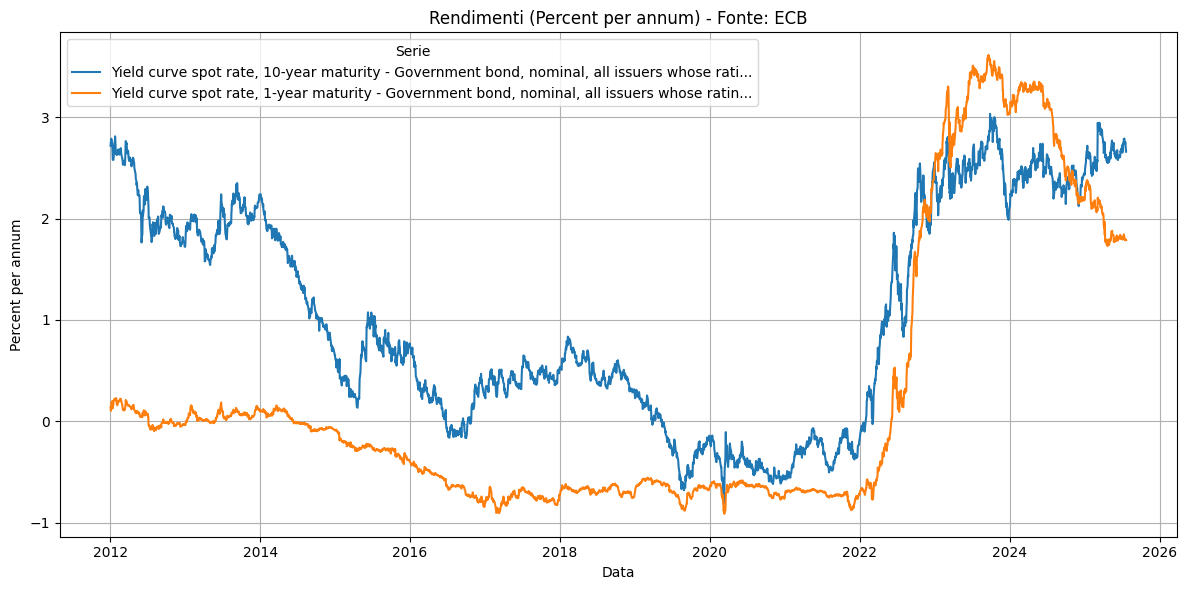

In [11]:
import matplotlib.pyplot as plt

# Applica i nomi delle colonne ottenuti da `get_column`
yc_df.columns = yc_columns

# Crea il grafico
plt.figure(figsize=(12, 6))
for col in yc_df.columns:
    plt.plot(yc_df.index, yc_df[col], label=col)

plt.title(f'Rendimenti ({yc_unit}) - Fonte: ECB')
plt.xlabel('Data')
plt.ylabel(yc_unit)
plt.legend(title='Serie')
plt.grid(True)
plt.tight_layout()
plt.show()
